## Pretraining on unlabeled data

In this chapter training function and pretrain the LLM will be presented. Basic model evaluation techniques will be introduced to measure the quality of the generated text, which is a must for optimizing the LLM during the training process.


###### *note: in the context of LLMs weights refer to the trainable parameters that are learned during the training stage. These weights are known as weight parameters or simply parameters. In PyTorch, these weights can be accessed by us through new_layer.weight or new_layer.parameters().*

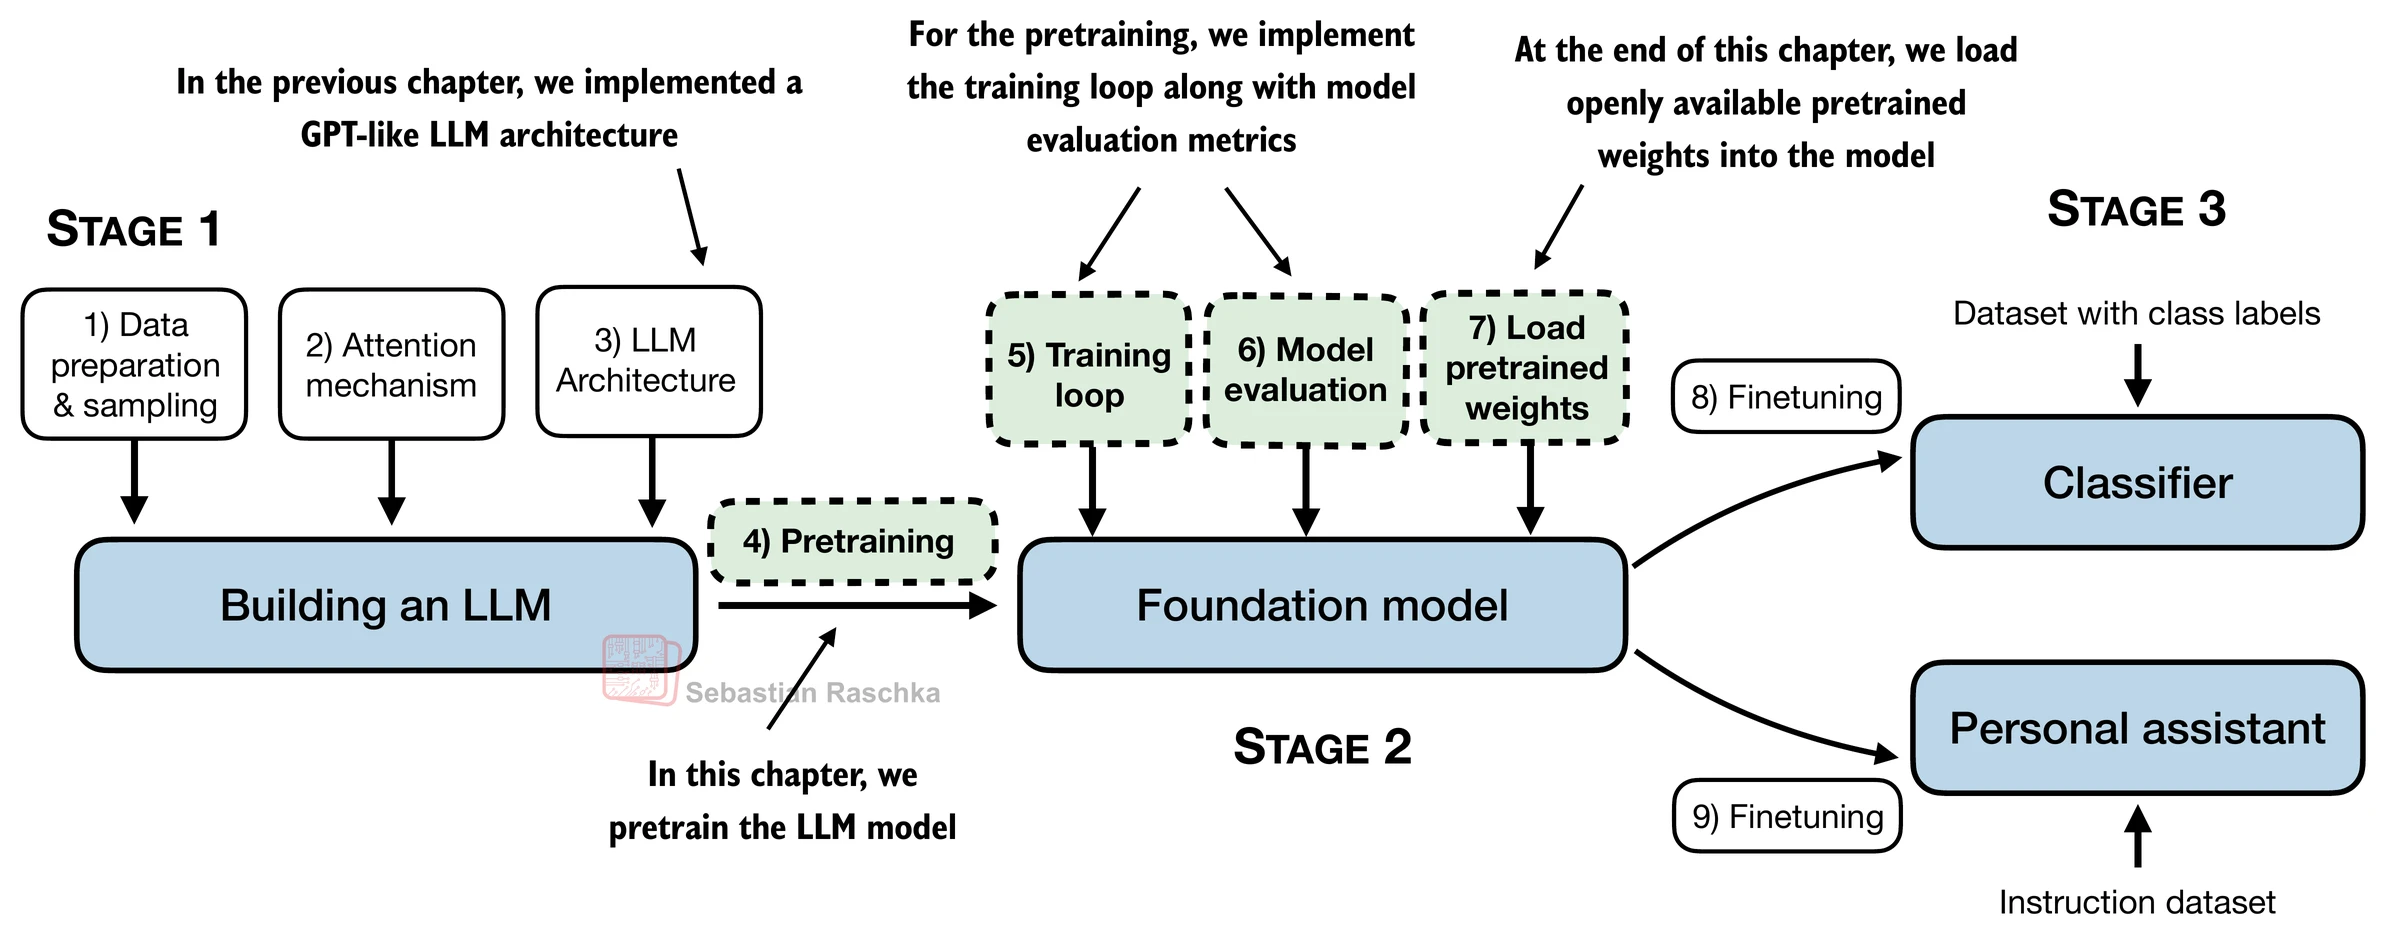

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.7
numpy version: 2.2.6
tiktoken version: 0.12.0
torch version: 2.9.0
tensorflow version: 2.20.0


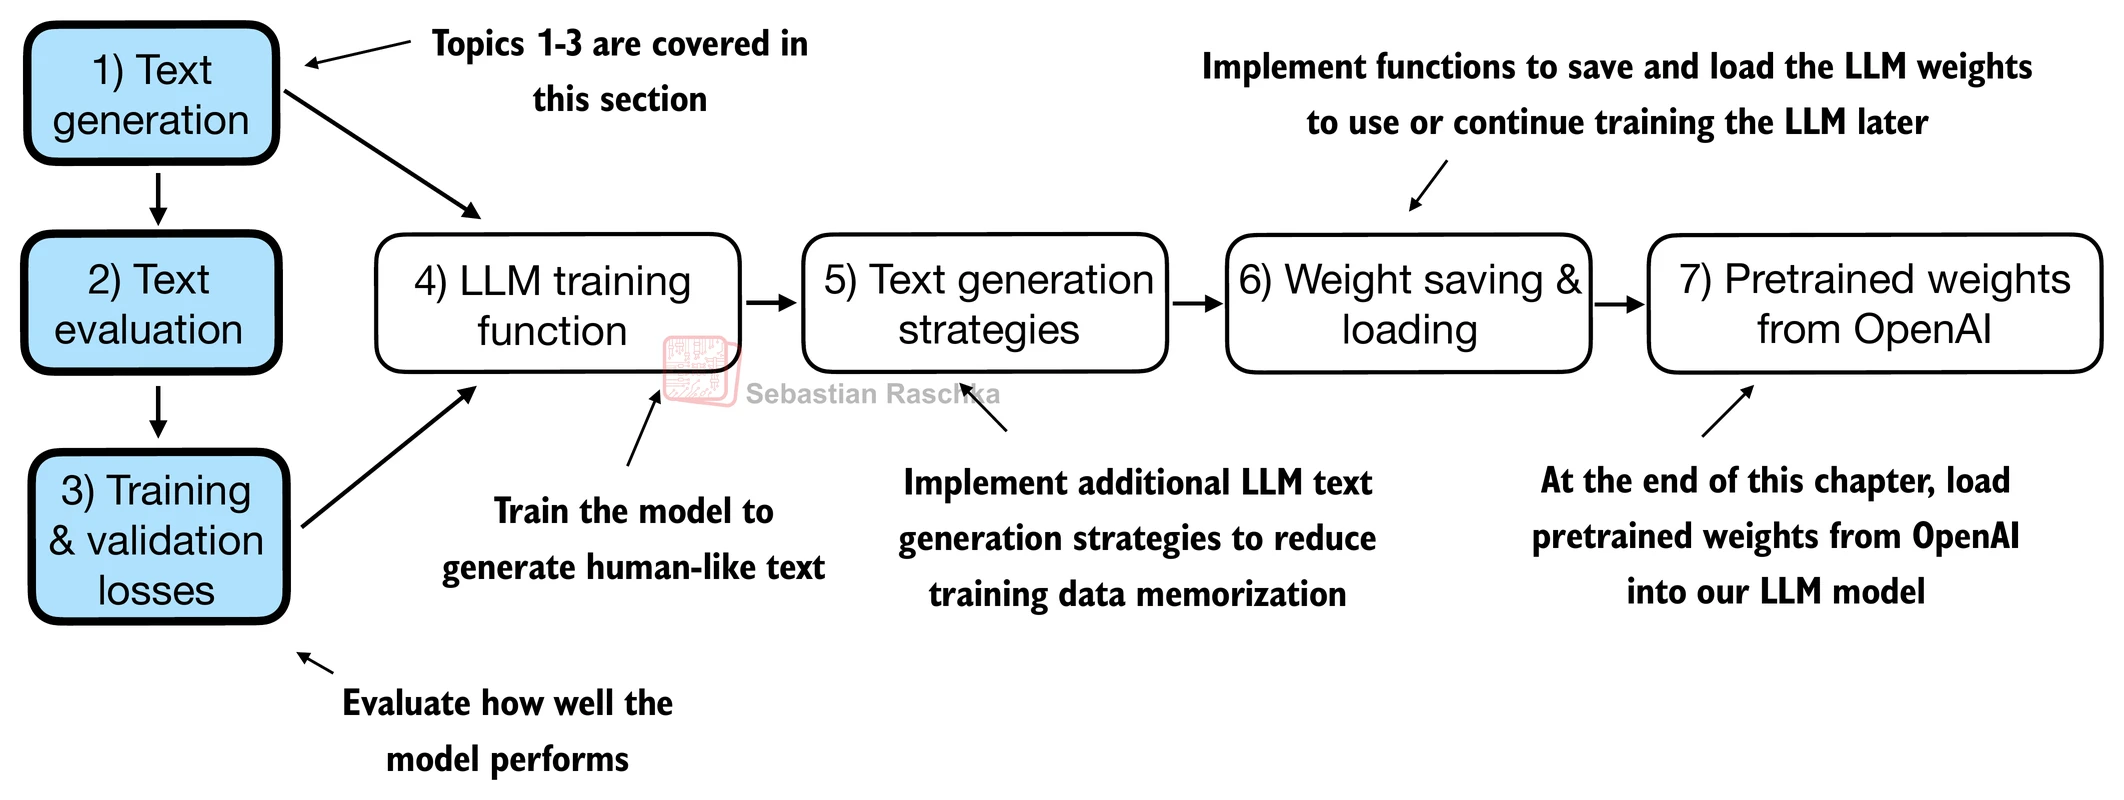

In [9]:
import torch
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from ch04.gpt import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024) for computational reasons
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

Let's introduce two different functions: text_to_token_ids and token_ids_to_text. These functions facilitate the conversion between text and token representations.

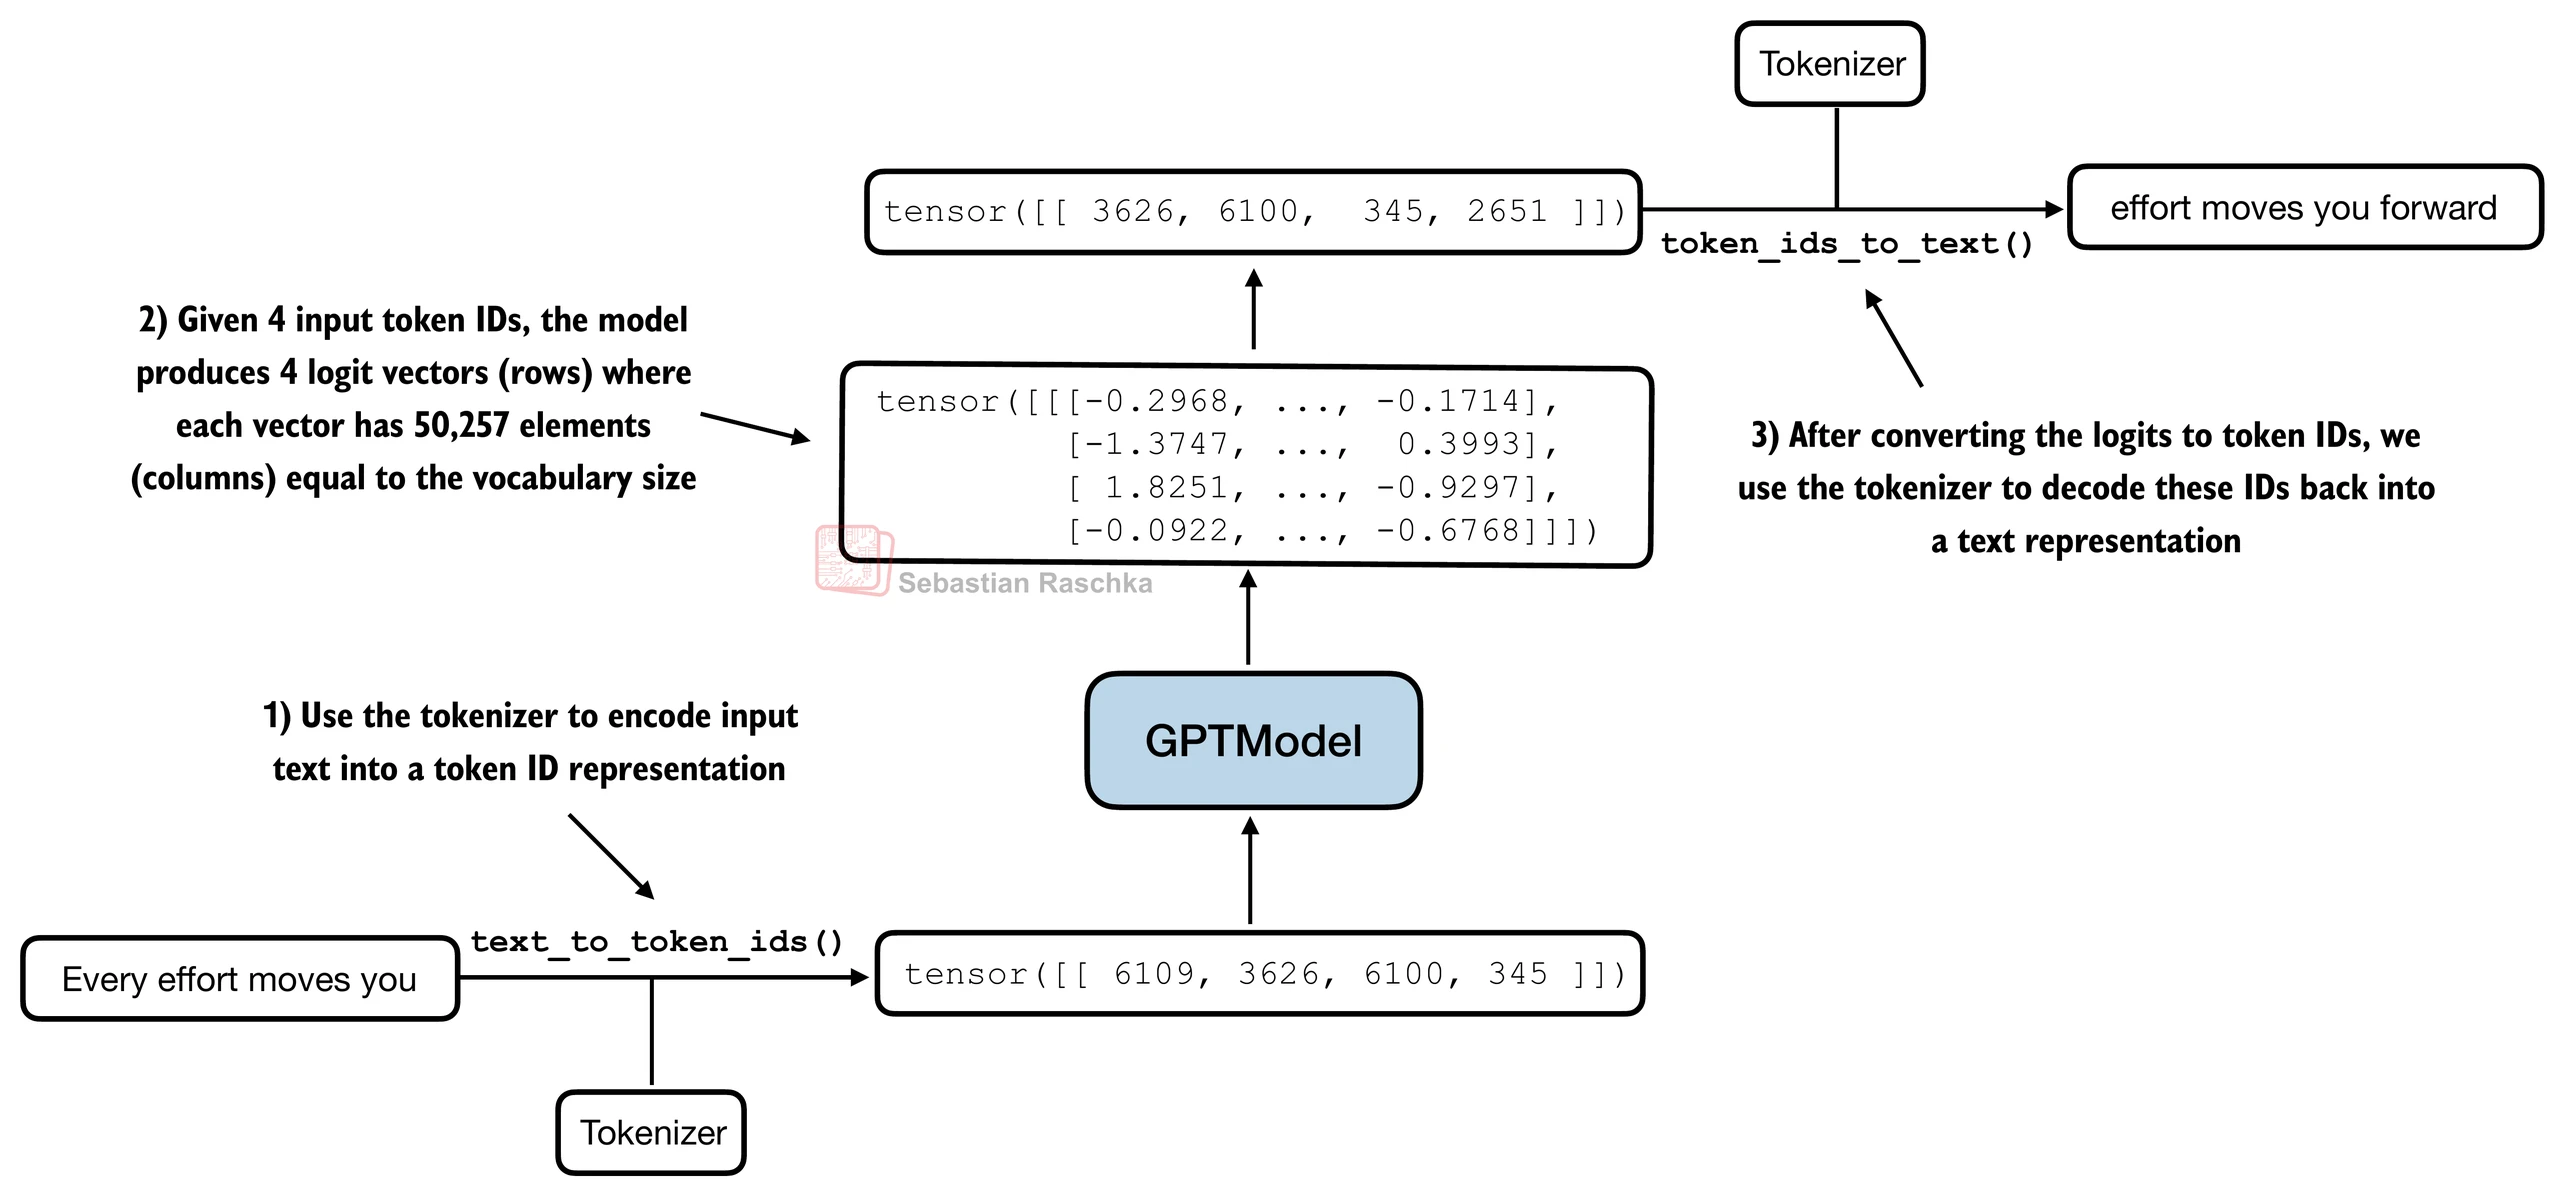

In [ ]:
import tiktoken
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from ch04.gpt import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


Clearly, the model isn't yet producing *coherent* text because it hasn't undergone training.
To define **coherent**, we have to implement a *numerical method* to evalutate the generated content.
This approach will enables us to monitor and enhance the model's performance throughout its training process.

#### Calculating the text generation loss: cross-entropy and perplexity
Let's introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress.


In [13]:
# Create inputs tensor containing the token IDs for 2 training examples (rows)
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

# Targets contain the desired token IDs that we want the model to generate
targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

# Notice that the targets are the inputs shifted by 1 position

# Now we feed the inputs into the model to calculate logits vectors for the two input examples, each comprising three tokens.
with torch.no_grad(): # disables gradient tracking since we are not training yet
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

# results comment: torch.Size([2, 3, 50257]) => 2 for the two examples (rows), 3 corresponds to the number of tokens, 50257 is the vocabulary size

torch.Size([2, 3, 50257])


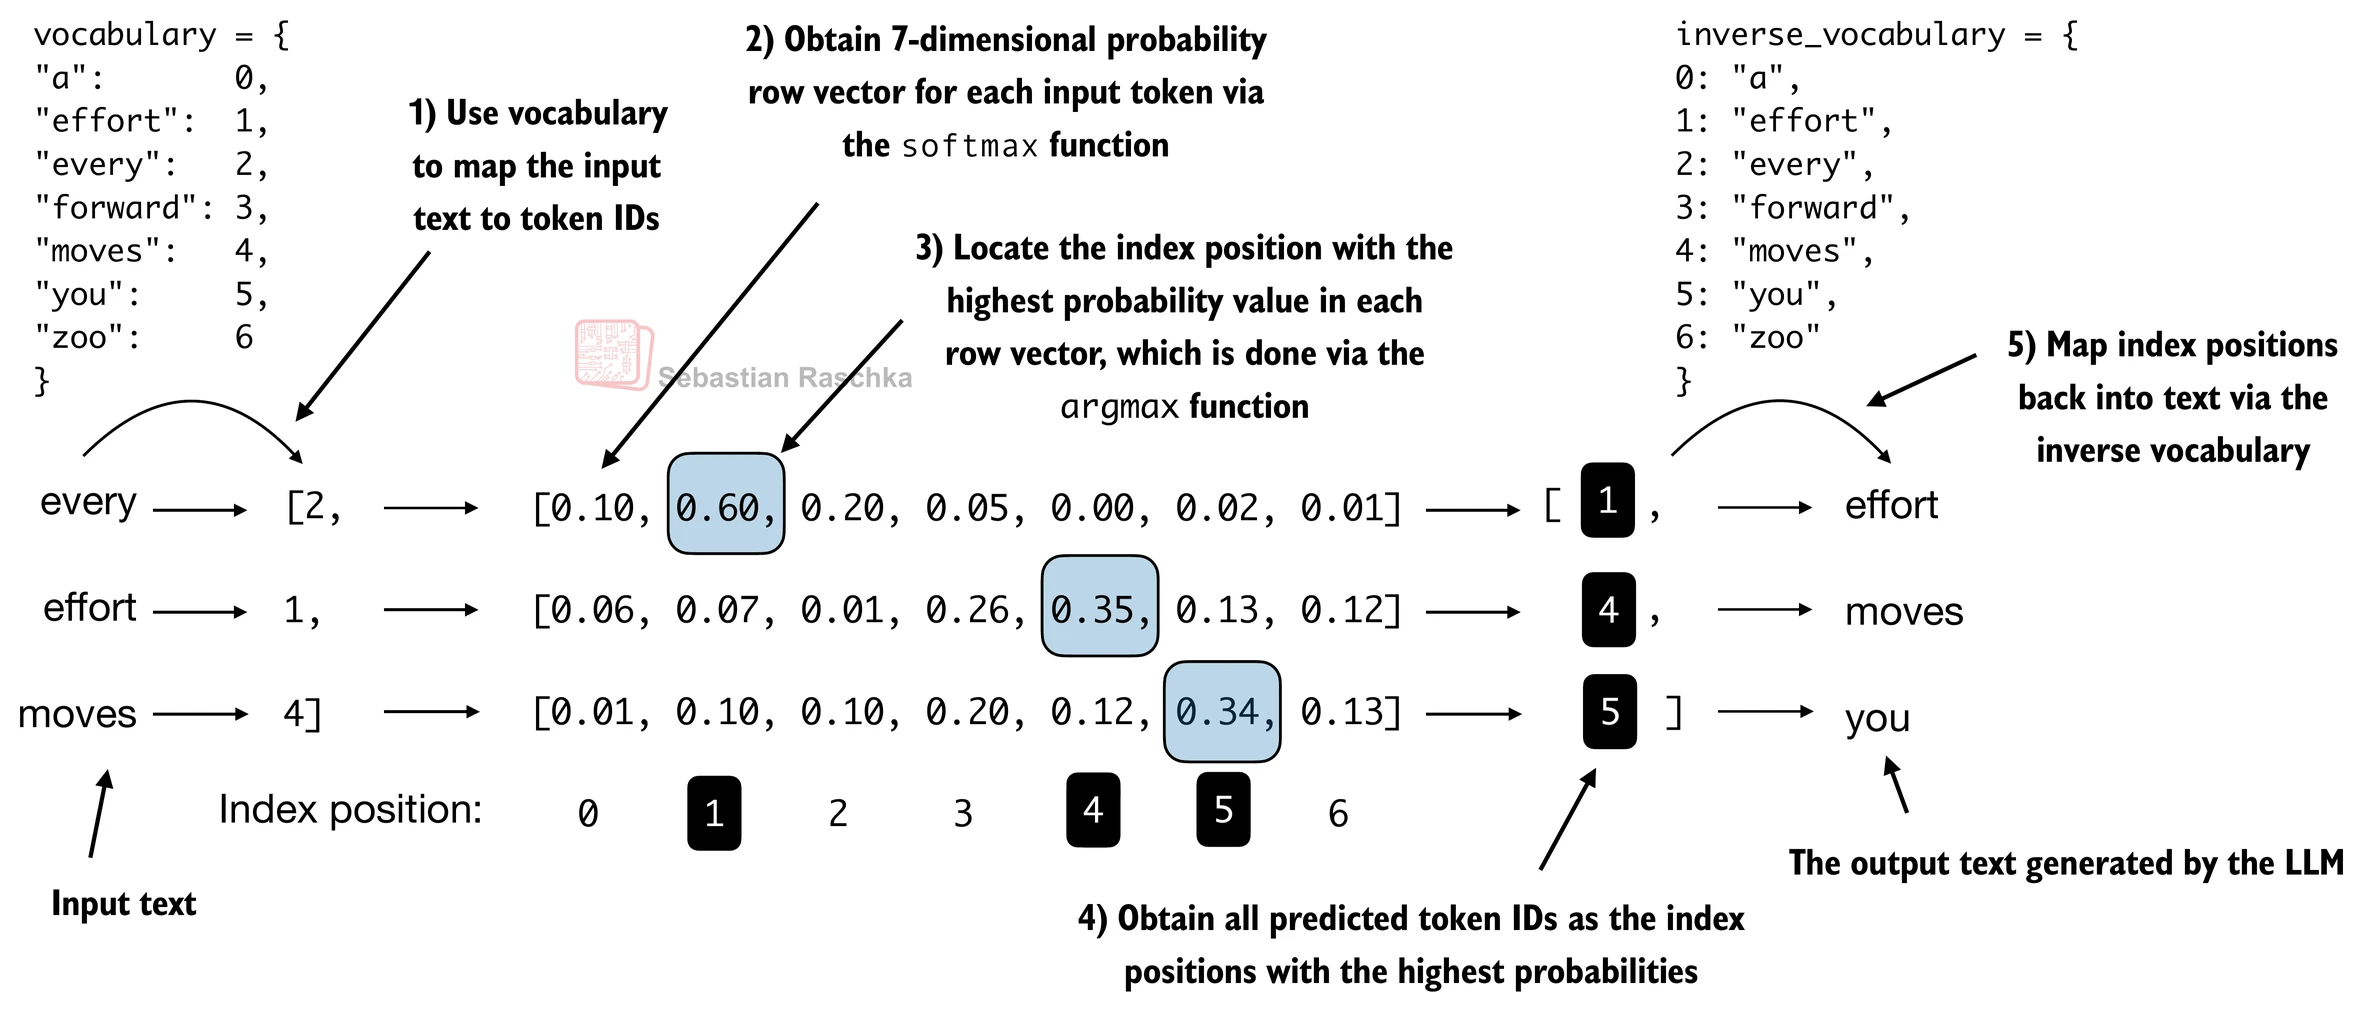

In [14]:
# from probs, argmax obtains the corresponing token IDs with highest probability
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [15]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


Results are different because the model wasn't trained yet. To train the model, we need to know *how far it is away from the correct predictions* (targets).
The training function use this information "how far ..." to adjust the model weights to generate text that is more similar to the target text.
The model training aims to increase the *softmax probability* in the index positions corresponding to the correct target token IDs.

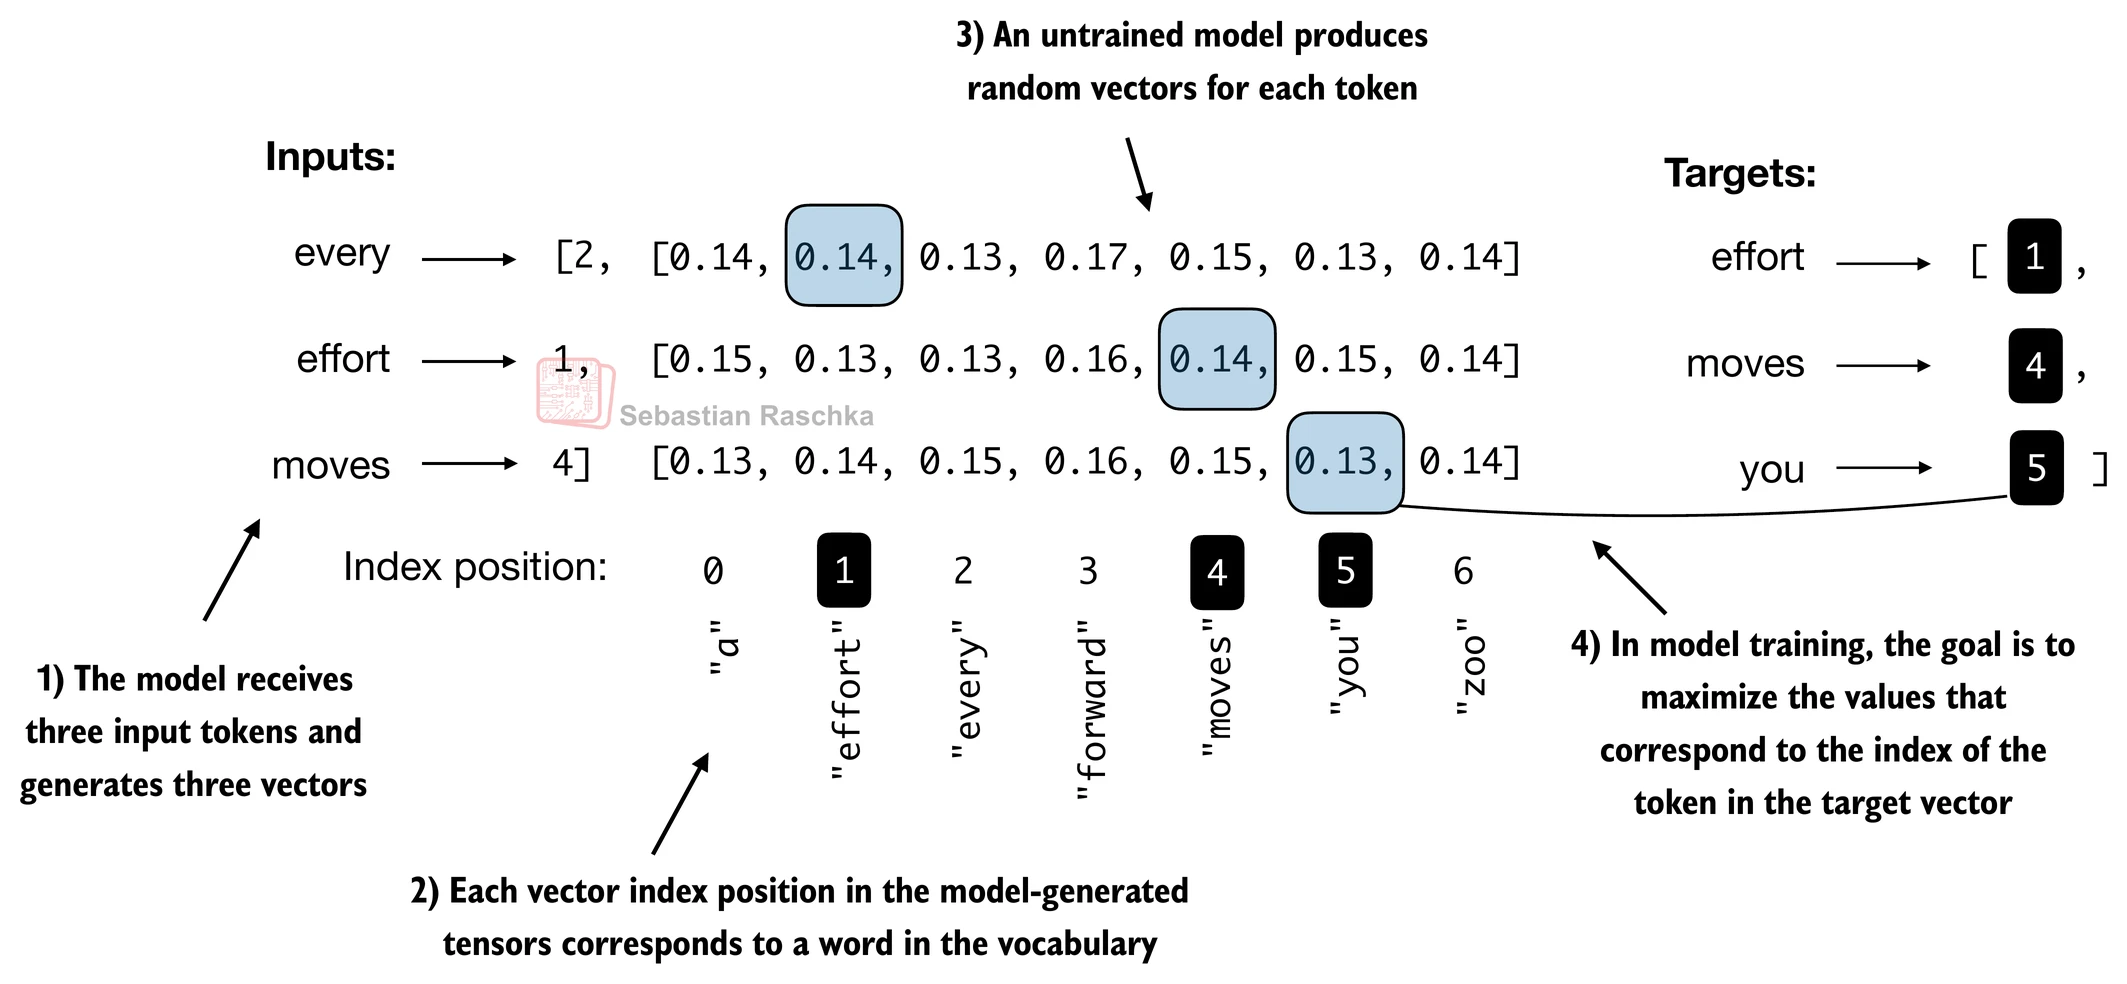

In [ ]:
# The token probabilities corresponding to the target indices are as follows:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


**TRAINING GOAL AND HOW TO ACHIVE THAT**
The goal of training an LLM is to maximize the likelihood of the correct token, which involves increasing its probability relative to other tokens.
In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself, Sebastina proposes a lecture with more details: [L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM).

TRAINING corresponds on updating the weights in order that the model outputs higher values for the respective token IDs we want to generate. The weight update is done via a process called **BACKPROPAGATION**. This process requires a *loss function*, which gives a measure of the difference between the model's predicted output and the desired output.

---

The calculation of the loss involves several steps.

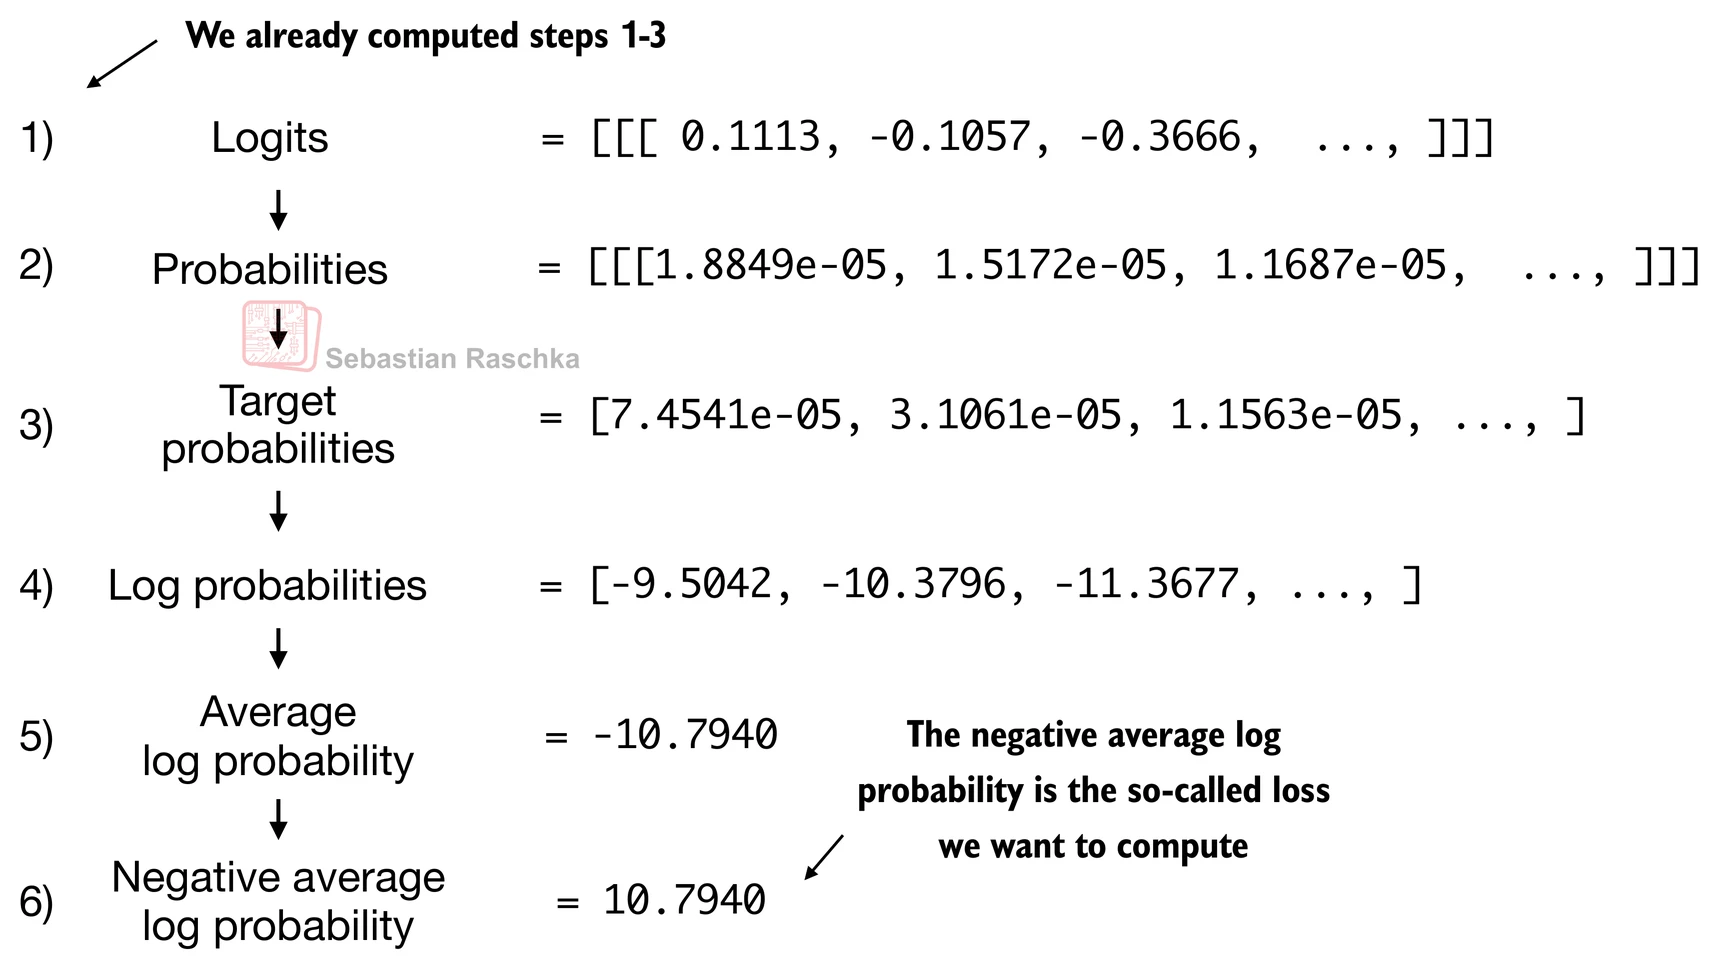


In [28]:
# Let's follow all steps.

# Steps 1 to 3, which we already done.

# Step 1
with torch.no_grad():
    logits = model(inputs)
print(f"Step 1 - Logits are : {logits}")
print(f"---" * 100)

# Step 2
probas = torch.softmax(logits, dim=-1)
print(f"Step 2 - Probabilities are : {logits}")
print(f"---" * 100)

# Step 3
# probas dimension : (batch_size, num_tokens, vocab_size)
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Step 3a - Target probabilities are : {target_probas_1}")
print(f" \n")
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Step 3b - Target probabilities are : {target_probas_2}")
print(f"---" * 100)

# Step 4
# Compute logarithm of all token probabilities (why log? It is more manageable in mathematical optimization than handling the score directly)
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(f"Step 4 - logarithm of all token probabilities are : {log_probas}")
print(f"---" * 100)

# Step 5
# Calculate the average probability for each token
'''The goal is to get teh avg log prob as close to 0 as possible'''
avg_log_probas = torch.mean(log_probas)
print(f"Step 5 - average probability for each token : {avg_log_probas}")
print(avg_log_probas)
print(f"---" * 100)

# Step 6
'''However, bringing teh neg avg prob down to zero is prefered respect to push teh avg up to 0'''
avg_log_probas = torch.mean(log_probas)
neg_avg_log_probas = avg_log_probas * -1
print(f"Step 6 - negative average probability for each token : {neg_avg_log_probas}")
print(f"---" * 100)


Step 1 - Logits are : tensor([[[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
         [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
         [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217]],

        [[-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
         [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
         [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]]])
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Step 2 - Probabilities are : tensor([[[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
         [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
         [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217]],

   

**CROSS_ENTROPY**

**The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning**
Cross-entropy function computes the difference between two probability distributions - typically, the true distribution of labes and the predicted distribution from a model. 


The term **cross-entropy** and **negative avarage log probability** related and often used interchangeably in pratice.


In [29]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [32]:
# For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension

# The logits contain the unscaled model output before they enter the softmax
logits_flat = logits.flatten(0, 1)
# targets are the token IDs we want the LLM to generate
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [33]:
# PyTorch does it automatically
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


**PERPLEXITY**

Perplexity is a measure often used alongside cross entropy loss to evaluate the performance of models in tasks like language modeling.
It provides a more **interpretable** way to understand the **uncertainty** of model in predicting the next token in a sequence.

*Perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset*

==> a lower perplexity indicates that the model predictions are closer to the actual distribution

In [34]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


#### Calculating the training and validation set losses

In [ ]:
####